In [5]:
# installations
!pip install cola-ml

In [6]:
# import modules
import cola
import torch
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
torch.manual_seed(21)

# Creating a Linear Operator

In [7]:
# defining a dense matrix and a vector to act upon
N = 4
A_dense = torch.randn(N, N)
vec = torch.randn(N)
print(f"A: {A_dense} \n\nvec: {vec}\n\nAv: {A_dense @ vec}")

A: tensor([[-0.2386, -1.0934,  0.1558,  0.1750],
        [-0.9526, -0.5442,  1.1985,  0.9604],
        [-1.1074, -0.8403, -0.0020,  0.2240],
        [ 0.8766, -0.5379, -0.2994,  0.9785]]) 

vec: tensor([ 0.6542,  0.0754, -1.0767,  0.1269])

Av: tensor([-0.3842, -1.8328, -0.7573,  0.9795])


In [8]:
# Creating a Dense Operator
A = cola.ops.Dense(A_dense)
print(type(A))

<class 'cola.ops.operators.Dense'>


In [9]:
# Checking the Operator Results the Same as the Dense Matrix
print(f"Dtype: {A.dtype} | Shape: {A.shape}")
print(A @ vec)

Dtype: torch.float32 | Shape: torch.Size([4, 4])
tensor([-0.3842, -1.8328, -0.7573,  0.9795])


In [10]:
# Large structured Linear Operators (memory and cost efficient)
ones = torch.ones(300)
upper = ones[:-1]
lower = ones[:-1]
diagonal= -2*ones

T = cola.ops.Tridiagonal(lower, diagonal, upper)
print(f"{T[:3,:3].to_dense()} \nType: {T}")

tensor([[-2.,  1.,  0.],
        [ 1., -2.,  1.],
        [ 0.,  1., -2.]]) 
Type: Tridiagonal


In [11]:
perm = torch.randperm(200)
P = cola.ops.Permutation(perm)
v = torch.randn(200)
print((P @ v)[:5], v[perm[:5]])

tensor([-0.4161, -0.2753,  1.9718,  0.0790, -0.1104]) tensor([-0.4161, -0.2753,  1.9718,  0.0790, -0.1104])


# Doing Binary Operations with Linear Ops

In [12]:
# Combine linear ops
D = cola.ops.Diagonal(torch.tensor([1, 2, 3, 4.]))
DT = T[:4, :4] - D
print(DT.to_dense())

tensor([[-3.,  1.,  0.,  0.],
        [ 1., -4.,  1.,  0.],
        [ 0.,  1., -5.,  1.],
        [ 0.,  0.,  1., -6.]])


Making $B= A^T(T_{[:4,:4]}-D) + \mu I$ (regularized by $\mu$) by using previous mentioned operators.

In [13]:
mu = 1e-6
B = A.T @ DT
B += mu * cola.ops.I_like(B)
print(f"Object: {B}\n {B.to_dense()}")

Object: DenseTridiagonal[slice(None, 4, None),slice(None, 4, None)]+-1.0diag(tensor([1., 2., 3., 4.]))+9.999999974752427e-07I
 tensor([[-0.2368,  2.4642,  5.4611, -6.3671],
        [ 2.7361,  0.2431,  3.1194,  2.3872],
        [ 0.7310, -4.6402,  0.9091,  1.7946],
        [ 0.4354, -3.4425,  0.8188, -5.6472]])


Linear Operators can also be combined in more involved ways
- kron
- block_diag
- concatenate

In [14]:
# Kronecker
K = cola.kron(A, D)
print(f"{K[:5,:5].to_dense()}\n\nshape: {K.shape},\n\nobject: {K}")

tensor([[-0.2386,  0.0000,  0.0000,  0.0000, -1.0934],
        [ 0.0000, -0.4772,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.7157,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.9543,  0.0000],
        [-0.9526,  0.0000,  0.0000,  0.0000, -0.5442]])

shape: (16, 16),

object: Dense⊗diag(tensor([1., 2., 3., 4.]))


In [15]:
# Block Diagonal
d = 1 / (1 + torch.linspace(.2, 10, 1000))
X = cola.block_diag(cola.kron(A, P), T, cola.ops.Diagonal(d))
X

<2100x2100 BlockDiag[cola.ops.operators.Kronecker[cola.ops.operators.Dense, cola.ops.operators.Permutation], cola.ops.operators.Tridiagonal, cola.ops.operators.Diagonal] with dtype=torch.float32>

# Computing Linaear Algebra Operations
- solves
- logdet
- diag
- exp
- and the list is long

Solve the linear system $Bx=v$ :

In [16]:
X[:, :5].to_dense().shape

torch.Size([2100, 5])

In [17]:
X_inv = cola.inv(X)
v = torch.randn(X.shape[-1])
soln = X_inv @ v
print(f"Solution error: {torch.linalg.norm(X @ soln - v)/torch.linalg.norm(v):.2e}")

Solution error: 4.37e-06


In [18]:
print(f"CoLA logdet: {cola.logdet(X):.3f} \ndense logdet {torch.logdet(X.to_dense()):.3f}")

CoLA logdet: -1564.690 
dense logdet -1564.690


In [19]:
print(f"CoLA diag: {cola.diag(X)[-5:]}\ndense diag: {torch.diag(X.to_dense())[-5:]}")

CoLA diag: tensor([0.0912, 0.0912, 0.0911, 0.0910, 0.0909])
dense diag: tensor([0.0912, 0.0912, 0.0911, 0.0910, 0.0909])


In [20]:
from scipy.linalg import expm
scipy_expm = expm((T.to_dense()).numpy())
print(f"CoLA exp(X):\n {cola.exp(T)[-5:,-5:].to_dense().real}\n\nscipy expm:\n {scipy_expm[-5:,-5:]}")

CoLA exp(X):
 tensor([[0.3085, 0.2153, 0.0932, 0.0288, 0.0066],
        [0.2153, 0.3085, 0.2152, 0.0930, 0.0275],
        [0.0932, 0.2152, 0.3083, 0.2139, 0.0864],
        [0.0288, 0.0930, 0.2139, 0.3016, 0.1865],
        [0.0066, 0.0275, 0.0864, 0.1865, 0.2153]])

scipy expm:
 [[0.30850834 0.21526879 0.09323523 0.02876082 0.0066488 ]
 [0.2152689  0.30850446 0.2152388  0.09302247 0.02746145]
 [0.09323529 0.21523878 0.30829173 0.21393949 0.08637363]
 [0.02876082 0.09302244 0.2139395  0.30164295 0.18647799]
 [0.0066488  0.02746145 0.08637366 0.18647805 0.21526927]]


In [21]:
from cola import Auto, Arnoldi
print(f"CoLA exp(X):\n {cola.exp(T, alg=Arnoldi())[-5:,-5:].to_dense().real}\n\nscipy expm:\n {scipy_expm[-5:,-5:]}")

CoLA exp(X):
 tensor([[0.3085, 0.2153, 0.0932, 0.0288, 0.0066],
        [0.2153, 0.3085, 0.2152, 0.0930, 0.0275],
        [0.0932, 0.2152, 0.3083, 0.2139, 0.0864],
        [0.0288, 0.0930, 0.2139, 0.3016, 0.1865],
        [0.0066, 0.0275, 0.0864, 0.1865, 0.2153]])

scipy expm:
 [[0.30850834 0.21526879 0.09323523 0.02876082 0.0066488 ]
 [0.2152689  0.30850446 0.2152388  0.09302247 0.02746145]
 [0.09323529 0.21523878 0.30829173 0.21393949 0.08637363]
 [0.02876082 0.09302244 0.2139395  0.30164295 0.18647799]
 [0.0066488  0.02746145 0.08637366 0.18647805 0.21526927]]


In [22]:
C = X.T @ X
# let's annotate this matrix as positive definite to speed up the computation
C = cola.PSD(C)
e, v = cola.eig(C, k=3, which="SM", alg=Auto(max_iters=500))
print(e, torch.linalg.eigh(C.to_dense())[0][:3])

tensor([2.5141e-06, 5.8988e-05, 1.5934e-04]) tensor([-1.8150e-07,  3.0996e-07,  1.9444e-06])


In [23]:
e, v = cola.eig(C, k=3, which="LM", alg=Auto(max_iters=500))
print(e, torch.linalg.eigh(C.to_dense())[0][-3:])

tensor([15.9922, 15.9965, 15.9991]) tensor([15.9922, 15.9965, 15.9991])


# Some Linear Algebra Functionality
- Inverse
- Matrix Functions
- Trace and Diagonal Estimation
- Log Determinants
- Eigendecompositon

Various linear algebra operations with an emphasis on the dense and iterative base cases, rather than the dispatch rules.

Some high level operations like `solve`, `sqrt`, `logdet`, `eigs`, `exp`, `trace`.

Some low level iterative functions helps implementing high level operations such as `cg`, `gmres`, `lanczos`, `approx_diag`, `stochastic_lanczos_quadrature`. Low level algorithms can also be called explicitly, will not be able to leverage dispatch rules.


Set up some Linear operators to test these operations on. As we want to focus on the base cases, we will use a simple low rank + diagonal linear operator. We will use $A=UU^T+D$ as a prototype for a PSD matrix, $B=UV^T+D$ as a prototype for a generic square matrix, and $C=V^TD$ as a prototype for a generic rectangular matrix.

In [24]:
# initializing sample data
N = 200
U = cola.lazify(torch.randn(N, 5))
V = cola.lazify(torch.randn(N, 5))
D = cola.ops.Diagonal(torch.linspace(1, 100, N))

A = U @ U.T + D  # a PSD matrix
B = U @ V.T + D  # a generic square matrix
C = V.T @ D  # a generic rectangular matrix

x = torch.ones(N)  # test vector x

In [25]:
# Setting matrix A as a PSD
print("Properties before annotating:", A.annotations)
A = cola.PSD(A)
print("Properties after annotating:", A.annotations)

Properties before annotating: set()
Properties after annotating: {PSD}


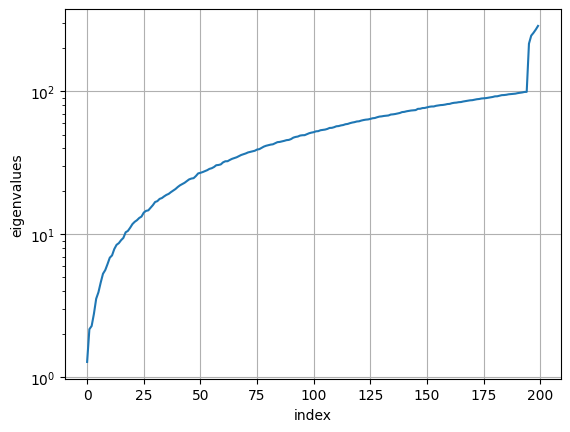

In [26]:
# Plot the spectrum of  A  to get a sense for the kind of object that we are dealing
plt.plot(torch.linalg.eigh(A.to_dense())[0])
plt.yscale('log')
plt.ylabel("eigenvalues")
plt.xlabel("index")
plt.grid()
plt.show()

## Inverses / Linear Solves

For solving a linear system $Ax=b$, we may consider two cases where $A$ is a Positive-SemiDefinite symmetric matrix (PSD), and when it is not.

`cola.linalg.inv(A)` represents the linear operator $A^{-1}$ that, when applied to a vector $b$, it solves the linear system $A x = b$ and then outputs $x$.
It does not, however, compute the inverse densely $A^{-1}$ and then multiply it by the vector $b$, and is exactly equivalent to calling `cola.linalg.solve`.


### PSD

In [27]:
# these two are exactly equivalent in CoLA
y = cola.linalg.solve(A, x)
y = cola.linalg.inv(A) @ x

However with `cola.linalg.inv` we can examine the properties of the solve like the number of iterations it as taken to converge. Instead using the default `alg=Auto()`, let's explicitly pick `alg=Cholesky()` to use a dense $O(n^3)$ method or `alg=CG()` to use an iterative $O(\tau \sqrt{\kappa}\log 1/\epsilon)$ where $\tau$ is the time for an MVM with $A$, $\kappa$ is the condition number of $A$ and $\epsilon$ is the desired error tolerance.

In [28]:
for alg in [cola.Cholesky(), cola.CG()]:
    Ainv = cola.linalg.inv(A, alg=alg)
    y = Ainv @ x
    print(f"With {alg}: Ainv of type {type(Ainv)}")
    if isinstance(alg, cola.CG):
        print(f"Computed inverse in {Ainv.info['iterations']} iters with error {Ainv.info['errors'][-1]:.1e}")

With <cola.linalg.decompositions.decompositions.Cholesky object at 0x7db029217970>: Ainv of type <class 'cola.ops.operators.Product[cola.linalg.inverse.inv.TriangularInv[cola.ops.operators.Triangular], cola.linalg.inverse.inv.TriangularInv[cola.ops.operators.Triangular]]'>
With CG(tol=1e-06, max_iters=1000, pbar=False, x0=None, P=None): Ainv of type <class 'cola.linalg.algorithm_base.IterativeOperatorWInfo[cola.ops.operators.Sum[cola.ops.operators.Product[cola.ops.operators.Dense, cola.ops.operators.Dense], cola.ops.operators.Diagonal], cola.linalg.inverse.cg.CG]'>
Computed inverse in 64 iters with error 1.7e-06


In the dense case the `inverse` LinearOperator is computed via Cholesky decomposition
$A = LL^T$, and then using $A^{-1} = L^{-T}L^{-1}$ where $L^{-1}$ simply means a Linear Operator that performs triangular solves with $L$. We can see this reflected in the type of `Ainv`.

Meanwhile the iterative algorithm uses Conjugate Gradients to perform multiplies with $A^{-1}$. With the iterative methods one often may want to specify an error tolerance or a maximum number of iterations to limit the computation.

In [29]:
# specify an error tolerance
Ainv = cola.linalg.inv(A, cola.CG(tol=1e-8, max_iters=1_000))
y = Ainv @ x
print(f"Computed inverse in {Ainv.info['iterations']} iters with error {Ainv.info['errors'][-1]:.1e}")

Computed inverse in 83 iters with error 1.4e-08


### Non PSD
Same functions but with the non PSD operator $B$.

In [30]:
for alg in [cola.LU(), cola.GMRES(tol=1e-3, max_iters=100)]:
    Binv = cola.linalg.inv(B, alg=alg)
    y = Binv @ x
    print(f"With {alg}: Ainv of type {type(Binv)}")
    if isinstance(alg, cola.GMRES):
        print(f"Computed inverse in {Binv.info['iterations']} iters with error {Binv.info['errors'][-1]:.1e}")

print(f"Actual residual error: {torch.linalg.norm(B @ y - x) / torch.linalg.norm(x):1.3e}")

With <cola.linalg.decompositions.decompositions.LU object at 0x7db0293f23e0>: Ainv of type <class 'cola.ops.operators.Product[cola.linalg.inverse.inv.TriangularInv[cola.ops.operators.Triangular], cola.linalg.inverse.inv.TriangularInv[cola.ops.operators.Triangular], cola.ops.operators.Permutation]'>
With GMRES(tol=0.001, max_iters=100, pbar=False, x0=None, P=None): Ainv of type <class 'cola.linalg.algorithm_base.IterativeOperatorWInfo[cola.ops.operators.Sum[cola.ops.operators.Product[cola.ops.operators.Dense, cola.ops.operators.Dense], cola.ops.operators.Diagonal], cola.linalg.inverse.gmres.GMRES]'>
Computed inverse in 101 iters with error 2.3e+01
Actual residual error: 1.941e-04


In the first case, CoLA performs a PLU decomposition $B=P^{-1}LU$ and then computes the inverse as $U^{-1}L^{-1}P$ again using the implicit triangular solves, but this time combined with a permutation inverse.

In the second case, CoLA uses GMRES. Notably GMRES uses Arnoldi as a component of the algorithm, and the convergence criteria for Arnoldi depends on more than just residual errors that we care about for the linear solve. As a result of this more stringent convergence criteria, GMRES hits `max_iters` before stopping from the Arnoldi convergence tolerance, and the errors can be more easily controlled via changing `max_iters`.

**Note:** In general CG has much more favorable properties over GMRES since with GMRES the memory requirement will grow with the number of iterations as will the compute, and hence if a matrix is PSD annotating it as such is highly preferable.

## Matrix Functions:

Broadly we can consider many functions linear algebra operations $A^{1/2}$, $\exp(A)$, $\log(A)$
as instances of $f(A)$ where $f$ is assumed to have a convergent Taylor expansion within the bounds of the spectrum of $A$.

For `alg = Auto()`, we compute these functions performing an eigendecomposition $A=P\Lambda P^{-1}$ and evaluate $f(A)=P f(\Lambda) P^{-1}$, and this runs in time $O(n^3)$.

For `alg = Lanczos()` or `alg = Arnoldi()`, we evaluate matrix vector products $f(A)v$ using the Lanczos and Arnoldi processes starting with the vector $v$. Running in time $O(\tau \sqrt{\kappa}\log 1/\epsilon+m^3+mn)$ where $m$ is `max_iters`, this approach gives $\epsilon$ accurate evaluation of $f(A)v$.

**Possibility:** With some extra effort the $m^3$ term can be reduced to $m^2$.

**Note:** For different $v$ the process will be run again, as Lanczos needs $v$ to construct a low error approximation.

### SelfAdjoint

Whether CoLA uses the more efficient Lanczos process or more costly version using Arnoldi depends on whether or not the matrix is `SelfAdjoint` (which guarantees an orthogonal eigenbasis).

**Note:** `SelfAdjoint` is considered a superset of `PSD`.

In [31]:
# checking self-adjointness
print(A.annotations)
print(f"PSD: {A.isa(cola.PSD)}, SelfAdjoint: {A.isa(cola.SelfAdjoint)}")

{PSD}
PSD: True, SelfAdjoint: True


In [32]:
for alg in [cola.Auto(), cola.Lanczos(tol=1e-4, max_iters=100)]:
    S = cola.linalg.sqrt(A, alg=alg)
    print(f"S with method={alg} is of type {type(S)}")
    print("error in sqrt:", torch.linalg.norm(S @ (S @ x) - A @ x) / torch.linalg.norm(A @ x))

S with method=Auto() is of type <class 'cola.ops.operators.Product[cola.ops.operators.Dense, cola.ops.operators.Diagonal, cola.ops.operators.Dense]'>
error in sqrt: tensor(1.7582e-06)
S with method=Lanczos(start_vector=None, max_iters=100, tol=0.0001, pbar=False, key=None) is of type <class 'cola.linalg.unary.unary.LanczosUnary[cola.ops.operators.Sum[cola.ops.operators.Product[cola.ops.operators.Dense, cola.ops.operators.Dense], cola.ops.operators.Diagonal], function]'>
error in sqrt: tensor(1.4695e-06)


In [33]:
# using exp, log, pow, and apply_fn
expA = cola.linalg.exp(-A)
logA = cola.linalg.log(A)
Apow10 = cola.linalg.pow(A, 10)
resolvent = cola.linalg.apply_unary(lambda x: 1 / (x - 1), A)
for op in [expA, logA, Apow10, resolvent]:
    print(op[:2, :2].to_dense())

tensor([[ 0.2528, -0.0429],
        [-0.0429,  0.1030]])
tensor([[0.4299, 0.2000],
        [0.2000, 1.0319]])
tensor([[2.8579e+22, 1.3096e+22],
        [1.3096e+22, 4.5881e+22]])
tensor([[ 3.1854, -0.6564],
        [-0.6564,  0.8918]])


### Non SelfAdjoint
For non self adjoint matrices the situation is the same, but it will use Arnoldi iterations. However, some of the operations like `log` and `sqrt` require that eigenvalues are $>0$ (positive) and may return Nan, Inf, or complex values depending on the inputs.

In [34]:
ops = [cola.linalg.sqrt(B), cola.linalg.exp(-B), cola.linalg.pow(B, 10)]
for op in ops:
    print(op[:2, :2].to_dense())

tensor([[1.2014+1.0990e-07j, 1.6245-2.6822e-07j],
        [0.6035+1.6391e-07j, 1.0500+2.9802e-08j]])
tensor([[ 0.4859-4.6566e-09j, -0.6837+3.9814e-08j],
        [-0.1905-2.3283e-10j,  0.3737-3.6089e-08j]])
tensor([[ 4.7804e+17-1.9327e+10j,  2.9943e+17-2.5126e+11j],
        [-8.5153e+16-3.8655e+10j, -1.7041e+17+1.0952e+11j]])


## Trace and Diagonal estimation

Unlike for dense matrices, evaluating the trace or diagonal of a `LinearOperators` can be difficult (consider for example the diagonal of the Hessian of a neural network). Depending on the needs for the problem at hand, multiple different solutions provided:
- an exact $O(n\tau)$ compute and $O(\tau)$ memory evaluation which loops over the basis elements $A_{ii} = e_i^TAe_i$
- an stochastic Hutchinson estimator which is unbiased (always), but has runtime $O(1/\delta^2)$ where $\delta$ is the desired tolerance for the standard deviation of the estimate.

These can be chosen directly by specifying `alg = Exact()`, `alg = Hutch()` or by letting the algorithm decide which will be faster `alg = Auto()` based on the specified tolerance for the standard deviation `tol`. In general for methods which only need stochastic estimates (such as to be used in SGD) or only need one or two digits of precision, then the stochastic estimator will be faster.

We can use either of these two methods for
- computing the trace
- computing the diagonal
- computing off-diagonal diagonals

In [35]:
# using Exact() and Hutch()
exact = cola.linalg.trace(A, alg=cola.Exact())
approx = cola.linalg.trace(A, alg=cola.Hutch(tol=3e-2))
print(f"exact trace: {exact},\nstochastic trace: {approx}")

exact trace: 11104.7470703125,
stochastic trace: 11105.77734375


In [36]:
# diagonal and off-diagonal
diag = cola.linalg.diag(A)
off_diag = cola.linalg.diag(A, k=1)
print(f"diagonal: {diag}")
print(f"off-diagonal: {off_diag}")

diagonal: tensor([  5.1523,   9.3551,   6.3290,   5.2218,   7.9162,   4.7325,  14.4950,
         10.7984,  21.1288,   8.7075,   8.5630,  13.3638,  11.4444,  12.4921,
         13.5327,  12.9951,  13.0147,  10.6328,  14.5388,  15.2480,  13.1034,
         16.4491,  15.6983,  14.2193,  15.3719,  17.0794,  21.0295,  16.3371,
         16.6937,  20.0624,  21.0491,  20.0134,  23.0473,  20.1628,  20.0862,
         21.3777,  21.3513,  22.2739,  22.8521,  22.4144,  28.6044,  24.2597,
         29.9020,  25.4927,  27.0707,  31.9253,  27.2471,  26.2500,  33.9902,
         28.7896,  32.5945,  34.0490,  31.6875,  29.4450,  29.4060,  30.6020,
         37.0120,  48.1053,  33.4597,  35.1445,  35.7544,  39.0811,  35.9896,
         35.3054,  36.7254,  37.4187,  40.4857,  37.2802,  36.9551,  42.9736,
         47.9623,  42.8532,  41.9808,  40.9772,  40.0723,  47.4184,  40.2504,
         50.5152,  47.1075,  53.2814,  48.2910,  43.2467,  47.2761,  44.6216,
         48.1712,  47.6787,  52.0565,  45.1480,  46.40

## Log Determinants

In the dense case, log determinants compute from the Cholesky or LU decompositions depending on whether the matrix is PSD or not, and this runs in time $O(n^3)$.

For the iterative case compute log determinants using the formula $\log\mathrm{det}(A) = \mathrm{Tr}(\log(A))$ combining together the $\log$ and $\mathrm{Tr}$ functions discussed above.

In the special case where only unbiased estimates (or a small number of significant digits) are required for the given use case, we can leverage [stochastic lanczos quadrature](https://www-users.cse.umn.edu/~saad/PDF/ys-2016-04.pdf) to get an improved convergence rate.

This choice is exposed to the user through the `log_alg` vs `trace_alg` options in `logdet` and `slogdet`.

In [37]:
print("Tr(log(A))", cola.linalg.logdet(A, trace_alg=cola.Hutch(tol=1e-4), log_alg=cola.Lanczos(tol=1e-4, max_iters=30)))
print("SLQ:", cola.linalg.logdet(A, log_alg=cola.Lanczos(tol=1e-3, max_iters=10), trace_alg=cola.Auto()))
print("Dense:", cola.linalg.logdet(A))

AssertionError: tolerance chosen too high for stochastic diagonal estimation

And we can do this for non PSD matrices too using $\log \mathrm{det}(A) = \frac{1}{2}\log \mathrm{det}(A^TA)$, however the phase (sign) is lost in this process.

In [38]:
print("iterative:", cola.linalg.slogdet(B, log_alg=cola.Arnoldi(tol=1e-3, max_iters=10)))
print("Dense:", cola.linalg.slogdet(B, log_alg=cola.LU()))

iterative: (tensor(1.0000+0.0007j), tensor(732.0270))
Dense: (tensor(-1.), tensor(731.0778))


## Eigendecomposition

Another popular linear algebra operation is to find an approximation for the eigenvalues or eigenvectors of given linear operator $A$. That is, find $V$ and $\Lambda$ such that $AV = V \Lambda$.

In [39]:
eig_vals, eig_vecs = cola.eig(A, k=A.shape[0])

Nevertheless, when $A$ is quite large we cannot afford the time or memory for a full decomposition. We could thus use an iterative eigenvalue algorithm such as power iteration (if we only want the maximum eigenvalue), Lanczos (if we have a symmetric operator) or Arnoldi (which works in general). Let's see how to run all of those options.
So to compute the maximum eigenvalue we could run the following code.

In [40]:
from cola.linalg.eig.power_iteration import power_iteration
_, eig_max, _ = power_iteration(A, tol=1e-4)
print(f"eigmax: {eig_max}")
print(f"eig_vals[0]: {eig_vals[-1]}")

eigmax: 287.3038024902344
eig_vals[0]: 287.5224609375


Indeed we recover the largest eigenvalue. The algorithm that `CoLA` ran in this case was the power method which runs in time $O(\tau\frac{1}{\Delta} \log 1/\epsilon)$ to compute the top eigenvalue. But we can achieve an accelerated convergence rate $O(\tau\frac{1}{\sqrt{\Delta}} \log 1/\epsilon)$ if we use Lanczos and Arnoldi, however this comes at an additional memory cost of $O(nm+m^2)$ where $m$ is `max_iters`.

In [41]:
e0, v0 = cola.eig(A, k=A.shape[0], which="SM", alg=cola.Lanczos(tol=1e-4, max_iters=15))
print(f"{e0[-1]}")

287.5223083496094


# Implementing new Linear Operators and Dispatch Rules

Implementing new linear operators in CoLA requires specifying a `shape`, `dtype`, and `matmat` functions.
Llike with scipy LinearOperator, there are two ways of doing so.

### Calling LinearOperator as a constructor

For a one off, a quick and dirty approach is to use the LinearOperator constructor directly. Let's assume we have some matrix vector multiply which is problem specific and not very generalizable.



In [42]:
def weird_matmat(x):
    # x of shape (100, d)
    return (x[2]+x[3])*torch.ones(5,1) - 3*x[3:]

shape = (5,8)
A = cola.ops.LinearOperator(torch.float32, shape, matmat=weird_matmat)
print(A.to_dense())

tensor([[ 0.,  0.,  1., -2.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  1., -3.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  1.,  0., -3.,  0.,  0.],
        [ 0.,  0.,  1.,  1.,  0.,  0., -3.,  0.],
        [ 0.,  0.,  1.,  1.,  0.,  0.,  0., -3.]])


### Subclassing LinearOperator

For a more extendible approach, and one that can leverage dispatch rules, recommend subclassing LinearOperator and defining the `__init__` calling `super().__init__(dtype,shape)`and defining a new `matmat` method.

In [43]:
# define a Diagonal LinearOperator
class MyDiagonal(cola.ops.LinearOperator):
    """ Diagonal LinearOperator. O(n) time and space matmuls"""
    def __init__(self, diag):
        super().__init__(dtype=diag.dtype, shape=(len(diag), ) * 2)
        self.diag = diag

    def _matmat(self, X):
        return self.diag[:, None] * X

    def __str__(self):
        return f"MyDiagonal({self.diag})"

In [44]:
A = MyDiagonal(jnp.arange(1,5))
print(A.to_dense())

[[1 0 0 0]
 [0 2 0 0]
 [0 0 3 0]
 [0 0 0 4]]


# Defining New Dispatch Rules

Implementing new dispatch rules for existing functions is easy, simply wrap the new function with a `cola.dispatch` decorator and define the functionality for a given `LinearOperator` and a given `Algorithm`. If you don't have a specific algorithm to use (as below) simply ensure that `alg: Algorithm` is part of the function's signature.


In [45]:
# extend inverse for the `MyDiagonal` object
from cola.linalg import inv
from cola.linalg.algorithm_base import Algorithm

@cola.dispatch
def inv(A: MyDiagonal, alg: Algorithm):
    print("Called my inverse:")
    return MyDiagonal(1 / A.diag)


A = MyDiagonal(torch.arange(1, 500000))
invA = inv(A)
print(invA)

Called my inverse:
MyDiagonal(tensor([1.0000e+00, 5.0000e-01, 3.3333e-01,  ..., 2.0000e-06, 2.0000e-06,
        2.0000e-06]))


In [46]:
# override existing functionality
"""@cola.dispatch
def inv(A: cola.ops.Dense, alg: Algorithm):
    print("Overrided the dense inverse")
    return cola.ops.Dense(torch.linalg.inv(A.to_dense()))


A = cola.ops.Dense(torch.arange(1, 5).reshape(2, 2).float())
invA = inv(A)
print(invA.to_dense())"""

'@cola.dispatch\ndef inv(A: cola.ops.Dense, alg: Algorithm):\n    print("Overrided the dense inverse")\n    return cola.ops.Dense(torch.linalg.inv(A.to_dense()))\n\n\nA = cola.ops.Dense(torch.arange(1, 5).reshape(2, 2).float())\ninvA = inv(A)\nprint(invA.to_dense())'

Implement entirely new linear algebra functions on existing objects, just make sure to have a base case.

In [47]:
# define a rowsum function that sums the rows of a LinearOperator
@cola.dispatch
def rowsum(A: cola.ops.LinearOperator):
    print("dispatched base case")
    return A @ A.xnp.ones(A.shape[:1], dtype=A.dtype, device=A.device)


@cola.dispatch
def rowsum(A: MyDiagonal):
    print("dispatched on MyDiagonal")
    return A.diag


A = MyDiagonal(torch.arange(5))
print(rowsum(A))

dispatched on MyDiagonal
tensor([0, 1, 2, 3, 4])


In [48]:
print(rowsum(cola.ops.Dense(torch.arange(4).reshape(2, 2))))

dispatched base case
tensor([1, 5])


# Accessing Lower Level Algorithms (CG, Lanczos, Arnoldi, etc)

In [49]:
# autoreload
%load_ext autoreload
%autoreload 2

import time
import torch
import cola
import jax.numpy as jnp
import warnings

warnings.filterwarnings('ignore')

In [50]:
# example matrix with a rapidly decaying spectrum
from cola.linalg.eig.power_iteration import power_iteration
N = 3_000
x = torch.linspace(-1, 1, N)
C = cola.lazify(torch.exp(-(x[None] - x[:, None])**2 / 2))
_, eigmax, _ = power_iteration(C, tol=1e-2)
C = C + 1e-4 * eigmax * cola.ops.I_like(C)

Run CG, GMRES to perform solves, or Lanczos and Arnoldi for decompositions to compute $f(A)v$ for a vector $v$ or for estimating the extremal eigenvalues.

In [51]:
y = torch.randn(C.shape[-1])
sol, info = cola.CG(tol=1e-4, pbar=True)(C, y)
sol1, info1 = cola.GMRES(tol=1e-4, pbar=True)(C, y)
Q1, T, info2 = cola.Lanczos(pbar=True, tol=1e-4, max_iters=1000)(C)
Q2, H, info3 = cola.Arnoldi(pbar=True, tol=1e-4, max_iters=1000)(C)

Running body_fun:   0%|          | 0/100 [00:00<?, ?it/s]

Running body_fun:   0%|          | 0/100 [00:00<?, ?it/s]

Running body_fun:   0%|          | 0/100 [00:00<?, ?it/s]

Running body_fun:   0%|          | 0/100 [00:00<?, ?it/s]

Information on the convergence criteria, number of iterations used, and the time per iteration is returned in the info dictionary. We can also use `pbar=True` to track the convergence with a tqdm progressbar.

In [52]:
print(info)

{'iterations': 14, 'errors': array([3.90765038e+01, 2.12092066e+00, 3.08053643e-01, 1.65023232e+00,
       6.37745857e-02, 6.14342988e-01, 2.24525020e-01, 2.42476381e-04,
       2.55159423e-04, 3.96560133e-03, 5.89033496e-03, 4.44327525e-05,
       4.44327525e-05]), 'iteration_time': 0.006042838096618652}


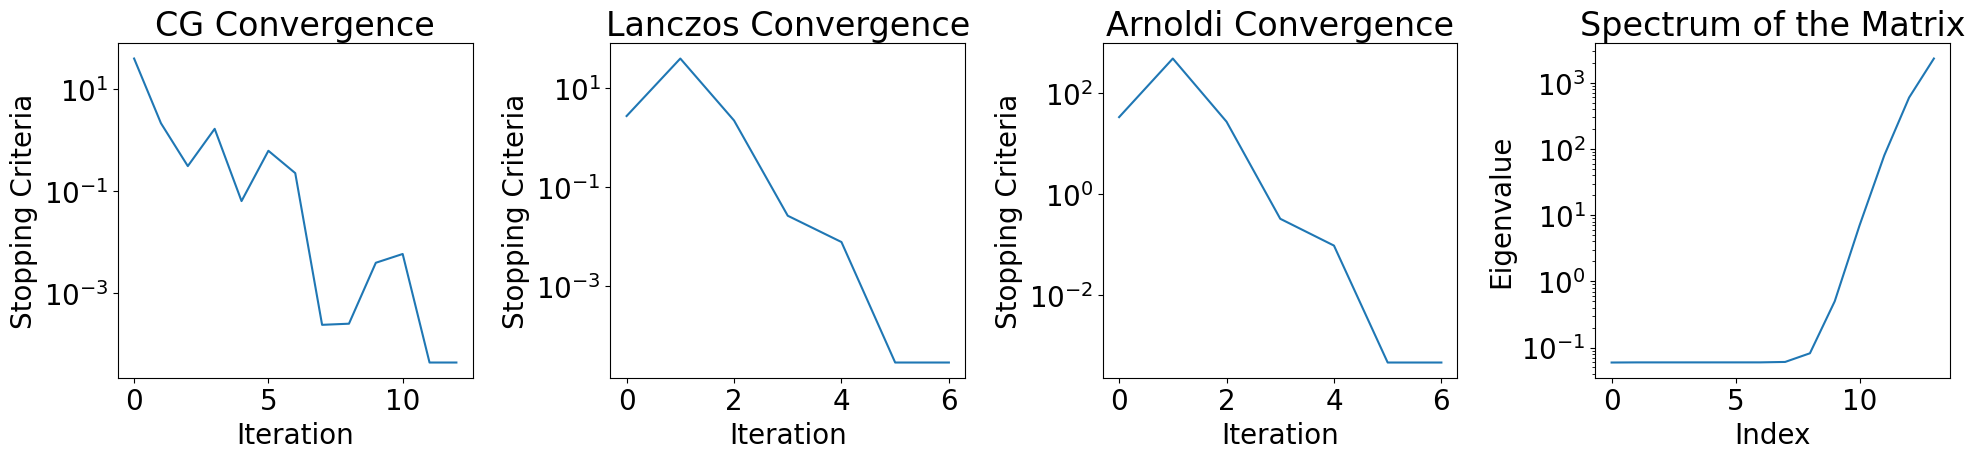

In [53]:
eigs = cola.eig(cola.SelfAdjoint(C), k=C.shape[0])[0]
# plot the convergence criteria for these different algorithms
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 20
algorithms = [('CG', info), ('Lanczos', info2), ('Arnoldi', info3)]
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, (name, info) in enumerate(algorithms):
    axs[i].plot(info['errors'])
    axs[i].set_yscale('log')
    axs[i].set_title(f'{name} Convergence')
    axs[i].set_xlabel('Iteration')
    axs[i].set_ylabel('Stopping Criteria')

axs[3].plot(eigs)
axs[3].set_yscale('log')
axs[3].set_title('Spectrum of the Matrix')
axs[3].set_xlabel('Index')
axs[3].set_ylabel('Eigenvalue')

plt.tight_layout()
plt.show()

For CG, the residual $\|Ax-b\|$ is the stopping criteria, whereas for Lanczos and Arnoldi it is diagonal entries in the Tridiagonal and Upper Hessenberg matrices respectively.

One tricky thing is that if you `jit` the algorithm or a function containing the algorithm, then the info dict will no longer be populated as jitted methods must always return arrays of the same shape. (though the progress bar will still be updated)

In [ ]:
import jax
import cola

C_jax = cola.lazify(jnp.array(C.to_dense()))
y_jax = jnp.array(y)


def mycg(C, y):
    return cola.CG(tol=1e-4, pbar=True)(C, y)


solj, infoj = jax.jit(mycg)(C_jax, y_jax)

In [1]:
print(infoj)

NameError: name 'infoj' is not defined